# Install and Import Libraries

In [1]:
pip install simpn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.2 MB/s eta 0:00:00


In [2]:
pip install pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.7 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=895fcb0d6f9af0bc7b0d63b9075c6a56bfa70c7a755dc95e822f24d1d92e42f2
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585896e83
Successfully built intervaltree


In [3]:
from simpn.simulator import SimProblem, SimToken
from random import expovariate as exp, uniform, choice
import simpn.prototypes as prototype
import json
from simpn.reporters import EventLogReporter

In [4]:
import pandas as pd
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.12/dist-packages/cudf/pandas/__init__.py:64: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


# Step 1: Model Happy Path

## Sequential Process Model

This step models an online food-delivery process using SimPN. It begins when an order is placed and ends when the meal is successfully delivered. Three sequential tasks move the order through the pipeline— payment confirmation, food preparation, and delivery —each requiring the appropriate resource (system, kitchen, or driver). The model declares the flow places (order_queue, paid, prepped, delivered_ok), allocates resources (system, kitchen, drivers), sets start and end events, and then runs a 40-hour simulation, exporting the resulting event log to sequence.csv.

In [5]:
food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
delivered_ok  = food.add_var("delivered_ok")

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")

drivers = food.add_var("drivers")
drivers.put("driver1")

# Dummy resource for automated tasks
system = food.add_var("system")
system.put("sys1")

def interarrival_time():
    return exp(4) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time)

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(5, 15))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [prepped, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# End
prototype.BPMNEndEvent(food, [delivered_ok], [], "delivery_success")

# Run
reporter = EventLogReporter("sequence.csv")
food.simulate(30 * 24 * 60, reporter)
reporter.close()

### Visualizing the Process with PM4Py

This step loads the simulated event log (sequence.csv) and visualizes the discovered Directly-Follows Graph (DFG) using PM4Py. It shows the main execution path of the loan process—from application_received to application_approved—based on simulation data.

In [6]:
def visualize_dfg_from_csv(csv_path):
    # Load and preprocess the CSV log
    df = pd.read_csv(csv_path, sep=",")
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['completion_time'] = pd.to_datetime(df['completion_time'])
    df = dataframe_utils.convert_timestamp_columns_in_df(df)

    # Format for PM4Py
    df = pm4py.format_dataframe(df, case_id='case_id', activity_key='task', timestamp_key='start_time')

    # Convert to event log
    event_log = log_converter.apply(df, variant=log_converter.TO_EVENT_LOG)

    # Discover and visualize DFG
    dfg = dfg_discovery.apply(event_log)
    gviz = dfg_visualizer.apply(dfg, event_log)
    dfg_visualizer.view(gviz)

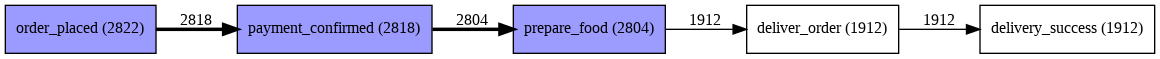

In [7]:
visualize_dfg_from_csv("sequence.csv")

## Adding a Choice

This section extends the base delivery model by adding a post-QC parallel block: cases notify the customer and assign a driver in parallel, then rejoin for delivery. After logging delivery success, a choice routes each case to either positive feedback or a complaint. The simulation runs for 30 * 24 hours and writes the log to extended.csv.

In [8]:
food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(4) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time)

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(5, 15))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, system],
    [qc_done, system],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

# --- Choice: Positive feedback vs Complaint (50/50) ---
def choose_outcome(token):
    if choice([True, False]):
        return [SimToken(token), None]   # to positive_fb
    else:
        return [None, SimToken(token)]   # to complaint_in

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

# Run
reporter = EventLogReporter("extended.csv")
food.simulate(30 * 24 * 60, reporter)
reporter.close()

### Visualizing the Process with PM4Py

This step loads the simulated event log (choice.csv) and visualizes the discovered Directly-Follows Graph (DFG) using PM4Py. It shows the main execution path of the loan process—from application_received to application_approved—based on simulation data.

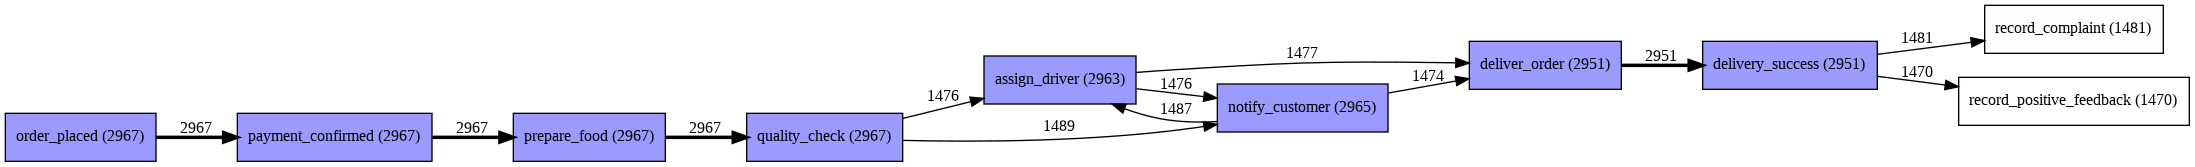

In [9]:
visualize_dfg_from_csv("extended.csv")

# Step 2: Add Case Attributes

Before adding custom attributes to each case, make sure the required files are downloaded from GitHub:

- `case_attributes.py` – script for injecting attributes into simulation cases  
- `custom_reporters.py` – custom reporter for exporting logs with enriched attributes  

Run the following to download the files:

In [10]:
import json

# Define your JSON content as a Python dictionary
config_data = {
    "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


In [11]:
!wget https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/attr/case_attributes.py
!wget https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/attr/custom_reporters.py

--2025-08-29 17:01:45--  https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/attr/case_attributes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2556 (2.5K) [text/plain]
Saving to: ‘case_attributes.py’

case_attributes.py  100%[===================>]   2.50K  --.-KB/s    in 0s      

2025-08-29 17:01:45 (33.8 MB/s) - ‘case_attributes.py’ saved [2556/2556]

--2025-08-29 17:01:45--  https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/attr/custom_reporters.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

### Inject Case Attributes into the Simulation

In this step, we enrich the event log with **custom attributes** such as `orderValue`, `isUrgentDelivery`, and `locationType`. These values are configured through `config.json` and injected at the start of each case using `start_behavior()` from `case_attributes.py`.

We also replace the standard reporter with `EnhancedEventLogReporter` from `custom_reporters.py` to ensure that these attributes are written into the generated event log.

Key changes:
- Load `config.json` into memory
- Use `start_behavior()` in the StartEvent
- Use `EnhancedEventLogReporter` for attribute-aware logging


Please refer to the **sequence model code above**. To enrich your simulation with custom case attributes, make the following adjustments:

**Step 1: Import required components**


```
from custom_reporters import EnhancedEventLogReporter
from case_attributes import start_behavior
import json
```



**Step 2: Load configuration from config.json**


```
with open('config.json', 'r') as f:
    config = json.load(f)
```



**Step 3: Modify the Start Event to include case attributes**


```
prototype.BPMNStartEvent(
    food,
    [],
    [order_queue],
    "order_placed",
    interarrival_time,
    behavior=lambda: start_behavior(food)
)
```


**Step 4: Use the enhanced reporter for enriched event logs**



```
reporter = EnhancedEventLogReporter("attributes.csv", config=config, sim_problem=food)
```


These changes will ensure each simulated case includes additional context such as `orderValue`, `isUrgentDelivery`, and `locationType`, as defined in `config.json`.

In [12]:
from custom_reporters import EnhancedEventLogReporter
from case_attributes import start_behavior

# Load configuration first to use in start_behavior
with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(4) * 60

# Start
prototype.BPMNStartEvent(
    food,
    [],
    [order_queue],
    "order_placed",
    interarrival_time,
    behavior=lambda: start_behavior(food)
)

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(5, 15))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, system],
    [qc_done, system],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

# --- Choice: Positive feedback vs Complaint (50/50) ---
def choose_outcome(token):
    if choice([True, False]):
        return [SimToken(token), None]   # to positive_fb
    else:
        return [None, SimToken(token)]   # to complaint_in

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

# Run
reporter = EnhancedEventLogReporter("attributes.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()

### Visualize Case Attributes

This section visualizes the enriched case attributes from the simulation log:

1. A **bar chart** categorizing orders by value into three bins (5–20, 21–50, 51–100).  
2. A **pie chart** showing the distribution of delivery urgency (`isUrgentDelivery`).  
3. A **pie chart** illustrating how many orders came from urban vs rural locations.  

Make sure the event log (e.g., `attributes.csv`) has been loaded with the `orderValue`, `isUrgentDelivery`, and `locationType` columns.


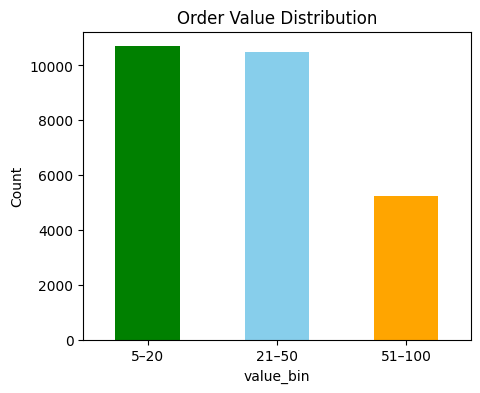

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("attributes.csv")  # Replace with your actual filename

# --- 1. Bar Chart: Order Value by Bins ---
def categorize_value(x):
    if 5 <= x <= 20:
        return "5–20"
    elif 21 <= x <= 50:
        return "21–50"
    elif 51 <= x <= 100:
        return "51–100"
    else:
        return "Other"

df['value_bin'] = df['orderValue'].apply(categorize_value)

# Ensure categorical order for plotting
bin_order = ["5–20", "21–50", "51–100"]
value_counts = df['value_bin'].value_counts().reindex(bin_order)

plt.figure(figsize=(5, 4))
value_counts.plot(kind='bar', color=['green', 'skyblue', 'orange'])
plt.title("Order Value Distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

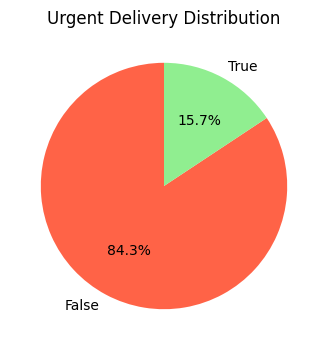

In [14]:
# --- 2. Pie Chart: Urgent vs Non-Urgent Deliveries ---
urgent_counts = df['isUrgentDelivery'].value_counts()

plt.figure(figsize=(5, 4))
urgent_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['tomato', 'lightgreen'])
plt.title("Urgent Delivery Distribution")
plt.ylabel("")
plt.show()

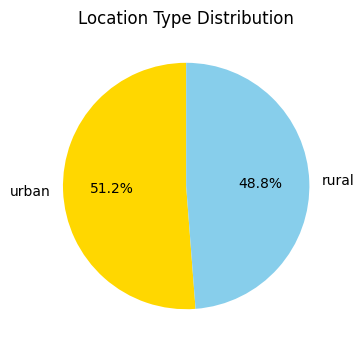

In [15]:
# --- 3. Pie Chart: Location Type ---
location_counts = df['locationType'].value_counts()

plt.figure(figsize=(5, 4))
location_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['gold', 'skyblue'])
plt.title("Location Type Distribution")
plt.ylabel("")
plt.show()

# Step 3: Introduce Rework Behavior

## Self-Loop Rework

In this step, we simulate a process where a task can repeat based on a configured probability. Specifically, we allow the `deliver_order` task to reoccur once with a 100% chance, simulating a rework loop.

This is achieved by:
1. Defining a rework configuration in `config.json`
2. Downloading the `rework.py` module from GitHub
3. Adding rework logic to the existing sequence model using `setup_rework()`
4. Running the simulation and visualizing the resulting self-loop behavior

The final event log is saved as `self_loop_rework.csv` and visualized using a Directly-Follows Graph (DFG).


In [16]:
import json

# Define the rework configuration
config_data = {
  "rework": [
    {
        "activity": "deliver_order",
        "max_iteration": 1,
        "probability": 1,
        "condition": "locationType == 'rural'"
    }
  ],
  "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


In [17]:
!wget https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/rework/rework.py

--2025-08-29 17:01:52--  https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/rework/rework.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9496 (9.3K) [text/plain]
Saving to: ‘rework.py’

rework.py           100%[===================>]   9.27K  --.-KB/s    in 0.001s  

2025-08-29 17:01:52 (15.7 MB/s) - ‘rework.py’ saved [9496/9496]



### Enable Self-Loop Rework

Using your previous sequence model, insert the following two lines:

**Step 1: Import the rework setup function from the `rework` module**


```
from rework import setup_rework
```



**Step 2: Call `setup_rework()`**


```
setup_rework(food, config)
```


In [18]:
from rework import setup_rework

# Load configuration first to use in start_behavior
with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(4) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(5, 15))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, system],
    [qc_done, system],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

# --- Choice: Positive feedback vs Complaint (50/50) ---
def choose_outcome(token):
    if choice([True, False]):
        return [SimToken(token), None]   # to positive_fb
    else:
        return [None, SimToken(token)]   # to complaint_in

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)

# Run
reporter = EnhancedEventLogReporter("self_loop_rework.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()

### Visualizing the Process with PM4Py

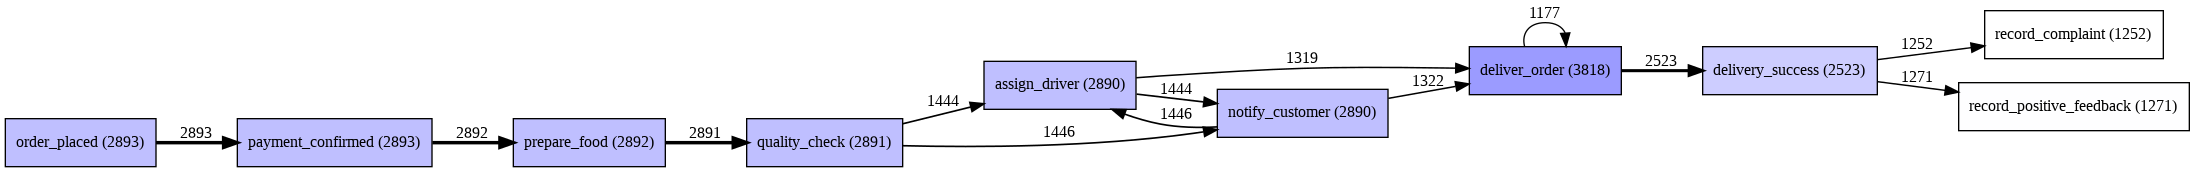

In [19]:
visualize_dfg_from_csv("self_loop_rework.csv")

## Long Rework

In this step, we simulate a scenario where a case reverts to a **previous task** based on a configured probability. Specifically, we allow the `quality_check` task to send the case back to `prepare_food` with a 50% chance, simulating a long rework path.

This is achieved by:

1. Defining a long rework configuration in `config.json`
2. Downloading the `rework.py` module from GitHub
3. Adding long rework logic to the existing sequence model using `setup_long_rework()`
4. Running the simulation and visualizing the rework behavior in the resulting log

The final event log is saved as `long_rework.csv` and can be visualized using a Directly-Follows Graph (DFG).


In [20]:
import json

# Define the rework configuration
config_data = {
  "rework": [
    {
        "activity": "deliver_order",
        "max_iteration": 1,
        "probability": 1,
        "condition": "locationType == 'rural'"
    }
  ],
  "long_rework": [
    {
      "trigger_activity": "quality_check",
      "back_to": "prepare_food",
      "max_iteration": 1,
      "probability": 0.5,
      "condition": "orderValue > 50"
    }
  ],
  "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


### Enable Long Rework

Using your previous sequence model, insert the following two lines:

**Step 1: Import the long rework setup function from the `rework` module**


```
from rework import setup_long_rework
```



**Step 2: Call `setup_long_rework()`**


```
setup_long_rework(food, config)
```


In [21]:
from rework import setup_rework, setup_long_rework

# Load configuration first to use in start_behavior
with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(4) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(5, 15))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, system],
    [qc_done, system],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

# --- Choice: Positive feedback vs Complaint (50/50) ---
def choose_outcome(token):
    if choice([True, False]):
        return [SimToken(token), None]   # to positive_fb
    else:
        return [None, SimToken(token)]   # to complaint_in

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)
setup_long_rework(food, config)

# Run
reporter = EnhancedEventLogReporter("long_rework.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()

### Visualizing the Process with PM4Py

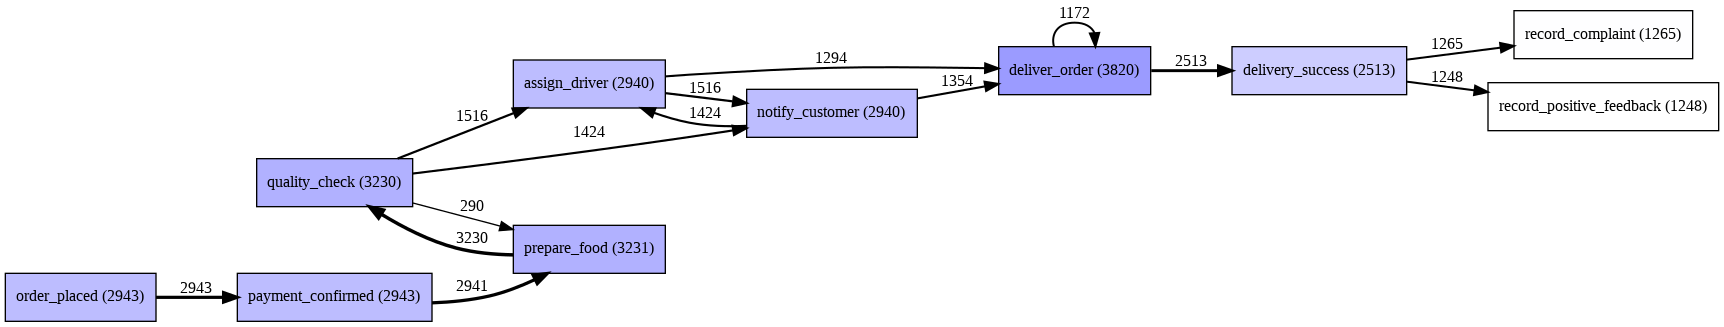

In [22]:
visualize_dfg_from_csv("long_rework.csv")

## Impact of Rework on Outcome Decisions

In this step, we simulate how rework affects the final outcome of a process.  
Specifically, we configure the model so that cases undergoing rework—such as repeating the `deliver_order` task—are more likely to result in a **negative outcome**, such as a complaint.  

This setup reflects realistic business behavior, where additional effort or backtracking can signal issues that reduce the likelihood of receiving positive feedback.

In [23]:
import json

# Define your JSON content as a Python dictionary
config_data = {
  "rework": [
    {
        "activity": "deliver_order",
        "max_iteration": 1,
        "probability": 1,
        "condition": "locationType == 'rural'"
    }
  ],
  "long_rework": [
    {
      "trigger_activity": "quality_check",
      "back_to": "prepare_food",
      "max_iteration": 1,
      "probability": 0.5,
      "condition": "orderValue > 50"
    }
  ],
  "decision": {
    "event_name": "choose_outcome",
    "normal": {
      "positive_probability": 0.5,
      "negative_probability": 0.5
    },
    "rework": {
      "positive_probability": 0.0,
      "negative_probability": 1.0
    },
    "positive_target": "record_positive_feedback",
    "negative_target": "record_complaint"
  },
  "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


**Modify the Outcome Logic Based on Rework Status**

In this step, we update the outcome decision so that results are **conditioned by whether rework occurred** during the case.  
This makes the simulation more realistic, as rework may indicate service issues and increase the likelihood of receiving a complaint instead of positive feedback.

**Before: Random Outcome**

The previous model used a simple 50/50 chance to produce either positive feedback or a complaint, without considering rework:


```
def choose_outcome(token):
    if choice([True, False]):
        return [SimToken(token), None]   # to positive_fb
    else:
        return [None, SimToken(token)]   # to complaint_in
```


**After: Rework-Conditioned Decision Logic**
Now, we check if the case went through rework using the has_rework attribute. If so, we adjust the outcome probabilities accordingly:



```
def choose_outcome(token):
    identifier, (attributes, rework_counts) = token
    if attributes.get("has_rework", False):
        positive_prob = config["decision"]["rework"]["positive_probability"]
    else:
        positive_prob = config["decision"]["normal"]["positive_probability"]
    if uniform(0, 1) < positive_prob:
        return [SimToken(token), None]  # Positive Feedback branch
    else:
        return [None, SimToken(token)]  # Complaint branch

```



In [24]:
from custom_reporters import EnhancedEventLogReporter
from case_attributes import start_behavior
from rework import setup_rework, setup_long_rework
import json

# Load configuration first to use in start_behavior
with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(4) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(5, 15))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, system],
    [qc_done, system],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

def choose_outcome(token):
    identifier, (attributes, rework_counts) = token
    if attributes.get("has_rework", False):
        positive_prob = config["decision"]["rework"]["positive_probability"]
    else:
        positive_prob = config["decision"]["normal"]["positive_probability"]
    if uniform(0, 1) < positive_prob:
        return [SimToken(token), None]  # Positive Feedback branch
    else:
        return [None, SimToken(token)]  # Complaint branch

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)
setup_long_rework(food, config)

# Run
reporter = EnhancedEventLogReporter("rework_outcomes.csv", config=config, sim_problem=food)
food.simulate(40 * 60, reporter)
reporter.close()


### Visualizing the Process with PM4Py

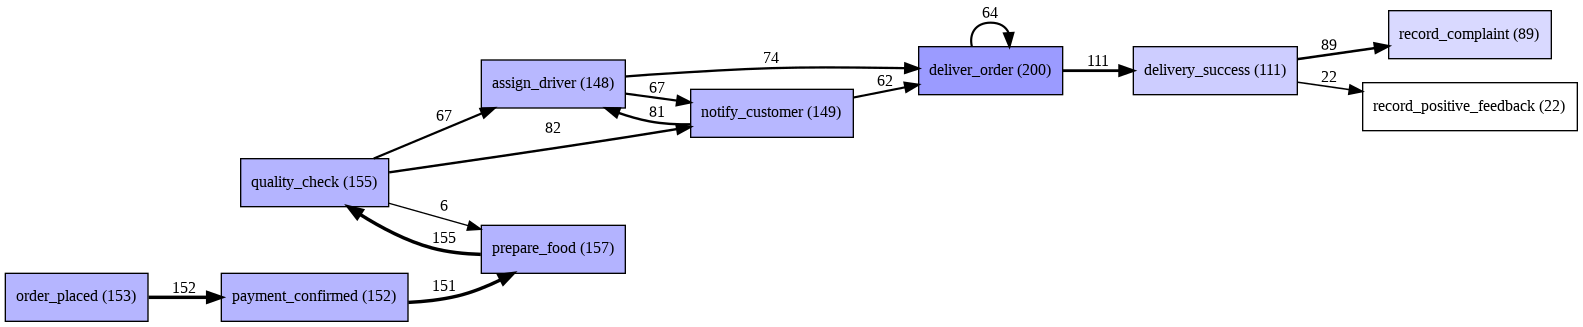

In [25]:
visualize_dfg_from_csv("rework_outcomes.csv")

# Step 4: Introduce Bottleneck

**What Is a Bottleneck?**

A bottleneck is any stage in a process where flow is constrained or delayed. Common causes include:
* Limited resources: fewer staff or machines available than needed.
* High demand: more work arriving than the stage can handle.
* Long task durations: the activity naturally takes longer than others.

By examining timestamps and task frequencies in your event log, you can pinpoint these choke points and take corrective action—such as adding capacity or rebalancing work—to improve overall throughput and cycle times.

Before adjusting your process to remove bottlenecks, it’s important to know exactly where and how many resources you’ll need. The next step is to calculate the optimal number of resources for each activity under your current workload—so you can right-size your staffing before re-running the simulation.


In [26]:
!wget https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/bottleneck/bottleneck_manager.py
!wget https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/bottleneck/resource_calculator.py
!wget https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/bottleneck/resource_constraints.py
!wget https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/bottleneck/task_constraints.py

--2025-08-29 17:02:20--  https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/bottleneck/bottleneck_manager.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15547 (15K) [text/plain]
Saving to: ‘bottleneck_manager.py’

bottleneck_manager. 100%[===================>]  15.18K  --.-KB/s    in 0.001s  

2025-08-29 17:02:20 (17.6 MB/s) - ‘bottleneck_manager.py’ saved [15547/15547]

--2025-08-29 17:02:20--  https://raw.githubusercontent.com/shofinadhiroh/simpn/refs/heads/main/bottleneck/resource_calculator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent

## Calculate Optimal Resources

In [27]:
import json

# Define your JSON content as a Python dictionary
config_data = {
  "rework": [
    {
        "activity": "deliver_order",
        "max_iteration": 1,
        "probability": 1,
        "condition": "locationType == 'rural'"
    }
  ],
  "long_rework": [
    {
      "trigger_activity": "quality_check",
      "back_to": "prepare_food",
      "max_iteration": 1,
      "probability": 0.5,
      "condition": "orderValue > 50"
    }
  ],
  "decision": {
    "event_name": "choose_outcome",
    "normal": {
      "positive_probability": 0.5,
      "negative_probability": 0.5
    },
    "rework": {
      "positive_probability": 0.0,
      "negative_probability": 1.0
    },
    "positive_target": "record_positive_feedback",
    "negative_target": "record_complaint"
  },
  "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


In [28]:
from resource_calculator import calculate_optimal_resources

with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")

manager = food.add_var("manager")
manager.put("manager1")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(10) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, manager],
    [qc_done, manager],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

def choose_outcome(token):
    identifier, (attributes, rework_counts) = token
    if attributes.get("has_rework", False):
        positive_prob = config["decision"]["rework"]["positive_probability"]
    else:
        positive_prob = config["decision"]["normal"]["positive_probability"]
    if uniform(0, 1) < positive_prob:
        return [SimToken(token), None]  # Approved branch
    else:
        return [None, SimToken(token)]  # Rejected branch

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)
setup_long_rework(food, config)

resources = calculate_optimal_resources(food)

# Run
reporter = EnhancedEventLogReporter("calculate_optimal_resource.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()


The amount of resources is not ideal and may cause bottlenecks.

The amount of resources for payment_confirmed is already ideal: 1
prepare_food should have 3 resources, but currently has 2
The amount of resources for quality_check is already ideal: 1
The amount of resources for notify_customer is already ideal: 1
The amount of resources for assign_driver is already ideal: 1
deliver_order should have 6 resources, but currently has 2
The amount of resources for delivery_success is already ideal: 1


## Adjust resource pools


Based on the calculator’s recommendations, we should increase our resource counts to meet the suggested levels (e.g. add cooks so that prepare_food has 3 cooks)

In [29]:
from resource_calculator import calculate_optimal_resources

with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")
kitchen.put("cook3")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")
drivers.put("driver3")
drivers.put("driver4")
drivers.put("driver5")
drivers.put("driver6")

manager = food.add_var("manager")
manager.put("manager1")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(10) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, manager],
    [qc_done, manager],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

def choose_outcome(token):
    identifier, (attributes, rework_counts) = token
    if attributes.get("has_rework", False):
        positive_prob = config["decision"]["rework"]["positive_probability"]
    else:
        positive_prob = config["decision"]["normal"]["positive_probability"]
    if uniform(0, 1) < positive_prob:
        return [SimToken(token), None]  # Approved branch
    else:
        return [None, SimToken(token)]  # Rejected branch

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)
setup_long_rework(food, config)

resources = calculate_optimal_resources(food)

# Run
reporter = EnhancedEventLogReporter("calculate_optimal_resource.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()


Resources look adequate (at 100% utilization).

The amount of resources for payment_confirmed is already ideal: 1
The amount of resources for prepare_food is already ideal: 3
The amount of resources for quality_check is already ideal: 1
The amount of resources for notify_customer is already ideal: 1
The amount of resources for assign_driver is already ideal: 1
The amount of resources for deliver_order is already ideal: 6
The amount of resources for delivery_success is already ideal: 1


## Time‐Based Resource Shortages

In [30]:
import json

# Define your JSON content as a Python dictionary
config_data = {
    "bottlenecks": {
      "type": "resource_shortage",
      "where": [
        {
          "task": "prepare_food",
          "periods": [
            {
              "start_date":          "2020-01-02",
              "end_date":            "2020-01-03",
              "resources_to_remove": ["cook1", "cook2"]
            }
          ]
        }
      ]
    },
    "rework": [
    {
        "activity": "deliver_order",
        "max_iteration": 1,
        "probability": 1,
        "condition": "locationType == 'rural'"
    }
  ],
  "long_rework": [
    {
      "trigger_activity": "quality_check",
      "back_to": "prepare_food",
      "max_iteration": 1,
      "probability": 0.5,
      "condition": "orderValue > 50"
    }
  ],
  "decision": {
    "event_name": "choose_outcome",
    "normal": {
      "positive_probability": 0.5,
      "negative_probability": 0.5
    },
    "rework": {
      "positive_probability": 0.0,
      "negative_probability": 1.0
    },
    "positive_target": "record_positive_feedback",
    "negative_target": "record_complaint"
  },
  "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


In [31]:
from bottleneck_manager import adjust_bottlenecks

# Load configuration first to use in start_behavior
with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")
kitchen.put("cook3")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")
drivers.put("driver3")
drivers.put("driver4")
drivers.put("driver5")
drivers.put("driver6")

manager = food.add_var("manager")
manager.put("manager1")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(10) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, manager],
    [qc_done, manager],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

def choose_outcome(token):
    identifier, (attributes, rework_counts) = token
    if attributes.get("has_rework", False):
        positive_prob = config["decision"]["rework"]["positive_probability"]
    else:
        positive_prob = config["decision"]["normal"]["positive_probability"]
    if uniform(0, 1) < positive_prob:
        return [SimToken(token), None]  # Approved branch
    else:
        return [None, SimToken(token)]  # Rejected branch

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)
setup_long_rework(food, config)

print("\nAdding Bottlenecks:\n")
adjust_bottlenecks(food, config)

# Run the simulation with the enhanced reporter
reporter = EnhancedEventLogReporter("adding_bottleneck.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()


Adding Bottlenecks:

Adding Time-Based Bottlenecks (e.g., summer holidays, Christmas, New Year):
- Simulating reduced resource availability during defined peak or holiday periods.

- Task: prepare_food
  - Initial Resources: 3
  - From 2020-01-02 to 2020-01-03: Resources removed: cook1, cook2

Resource Settings Over Time:
- prepare_food:
  - Normally: 3 resources
  - During 2020-01-02 to 2020-01-03: Resources cook1, cook2 are unavailable

Potential Impacts:
- During 2020-01-02 to 2020-01-03 for 'prepare_food':
  - Resources removed: cook1, cook2
  - Potential bottleneck: Increased waiting times for 'prepare_food' due to unavailability of specific resources.

Note: These reductions reflect temporary constraints in resource availability during specified periods.


## Simulating Bottlenecks by Restricting Task Execution to Specific Resources

In [32]:
import json

# Define your JSON content as a Python dictionary
config_data = {
    "resource_constraints": [
        {
            "task": "prepare_food",
            "conditions": [
                {
                    "condition": "orderValue > 50",
                    "resources": ["cook1"]
                }
            ]
        }
    ],
    "rework": [
    {
        "activity": "deliver_order",
        "max_iteration": 1,
        "probability": 1,
        "condition": "locationType == 'rural'"
    }
  ],
  "long_rework": [
    {
      "trigger_activity": "quality_check",
      "back_to": "prepare_food",
      "max_iteration": 1,
      "probability": 0.5,
      "condition": "orderValue > 50"
    }
  ],
  "decision": {
    "event_name": "choose_outcome",
    "normal": {
      "positive_probability": 0.5,
      "negative_probability": 0.5
    },
    "rework": {
      "positive_probability": 0.0,
      "negative_probability": 1.0
    },
    "positive_target": "record_positive_feedback",
    "negative_target": "record_complaint"
  },
  "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


In [33]:
from resource_constraints import apply_resource_constraints

from bottleneck_manager import adjust_bottlenecks

# Load configuration first to use in start_behavior
with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")
kitchen.put("cook3")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")
drivers.put("driver3")
drivers.put("driver4")
drivers.put("driver5")
drivers.put("driver6")

manager = food.add_var("manager")
manager.put("manager1")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(10) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, manager],
    [qc_done, manager],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

def choose_outcome(token):
    identifier, (attributes, rework_counts) = token
    if attributes.get("has_rework", False):
        positive_prob = config["decision"]["rework"]["positive_probability"]
    else:
        positive_prob = config["decision"]["normal"]["positive_probability"]
    if uniform(0, 1) < positive_prob:
        return [SimToken(token), None]  # Approved branch
    else:
        return [None, SimToken(token)]  # Rejected branch

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)
setup_long_rework(food, config)

apply_resource_constraints(food, config)

# Run the simulation with the enhanced reporter
reporter = EnhancedEventLogReporter("apply_resource_constraints.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()


Resource Constraints:

Task: prepare_food
  - If orderValue > 50: Only resource cook1 is allowed.



## Task Scheduling Constraints


In [34]:
import json

# Define your JSON content as a Python dictionary
config_data = {
  "task_constraints": {
    "prepare_food": {
      "type": "day_of_week",
      "days": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    }
  },
  "rework": [
    {
        "activity": "deliver_order",
        "max_iteration": 1,
        "probability": 1,
        "condition": "locationType == 'rural'"
    }
  ],
  "long_rework": [
    {
      "trigger_activity": "quality_check",
      "back_to": "prepare_food",
      "max_iteration": 1,
      "probability": 1,
      "condition": "orderValue > 50"
    }
  ],
  "decision": {
    "event_name": "choose_outcome",
    "normal": {
      "positive_probability": 0.5,
      "negative_probability": 0.5
    },
    "rework": {
      "positive_probability": 0.0,
      "negative_probability": 1.0
    },
    "positive_target": "record_positive_feedback",
    "negative_target": "record_complaint"
  },
  "case_attributes": {
    "orderValue": {
      "type": "numerical",
      "distribution": {
        "type": "bins",
        "bins": [
          {"range": [5, 20], "probability": 0.4},
          {"range": [21, 50], "probability": 0.4},
          {"range": [51, 100], "probability": 0.2}
        ]
      }
    },
    "isUrgentDelivery": {
      "type": "boolean",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": True, "probability": 0.15},
          {"value": False, "probability": 0.85}
        ]
      }
    },
    "locationType": {
      "type": "string",
      "distribution": {
        "type": "discrete",
        "values": [
          {"value": "urban", "probability": 0.5},
          {"value": "rural", "probability": 0.5}
        ]
      }
    }
  }
}

# Save to config.json
with open("config.json", "w") as f:
    json.dump(config_data, f, indent=4)

print("✅ config.json has been saved.")

✅ config.json has been saved.


In [ ]:
from task_constraints import apply_task_constraints

# Load configuration first to use in start_behavior
with open('config.json', 'r') as f:
    config = json.load(f)

food = SimProblem()

# Places
order_queue   = food.add_var("order_queue")
paid          = food.add_var("paid")
prepped       = food.add_var("prepped")
qc_done        = food.add_var("qc_done")          # output of quality_check

# Parallel block after QC
notify_queue       = food.add_var("notify_queue")       # input to notify branch
assign_queue       = food.add_var("assign_queue")       # input to assign-driver branch
wait_sync_w_assign = food.add_var("wait_sync_w_assign") # result of notify branch waiting for join
wait_sync_w_notify = food.add_var("wait_sync_w_notify") # result of assign-driver branch waiting for join
ready_to_deliver   = food.add_var("ready_to_deliver")   # after AND-join

# Downstream
delivered_ok  = food.add_var("delivered_ok")
post_success  = food.add_var("post_success")   # NEW: after 'delivery_success'
positive_fb   = food.add_var("positive_fb")    # NEW: positive outcome
complaint_in  = food.add_var("complaint_in")   # NEW: complaint outcome

# Resources
kitchen = food.add_var("kitchen")
kitchen.put("cook1")
kitchen.put("cook2")
kitchen.put("cook3")
kitchen.put("cook4")

drivers = food.add_var("drivers")
drivers.put("driver1")
drivers.put("driver2")
drivers.put("driver3")
drivers.put("driver4")
drivers.put("driver5")
drivers.put("driver6")

manager = food.add_var("manager")
manager.put("manager1")

system = food.add_var("system")
system.put("sys1")

notifier = food.add_var("notifier")
notifier.put("notifier1")

# Dummy resource for automated tasks
dispatcher = food.add_var("dispatcher")
dispatcher.put("dispatcher1")

def interarrival_time():
    return exp(10) * 60

# Start
prototype.BPMNStartEvent(food, [], [order_queue], "order_placed", interarrival_time, behavior=lambda: start_behavior(food))

# Payment Confirmed (automated but needs a resource var)
def payment_confirmed_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [order_queue, system],
    [paid, system],
    "payment_confirmed",
    payment_confirmed_start
)

# Prepare Food
def prepare_food_start(c, r):
    return [SimToken((c, r), delay=uniform(10, 20))]

prototype.BPMNTask(
    food,
    [paid, kitchen],
    [prepped, kitchen],
    "prepare_food",
    prepare_food_start
)

# Quality Check (before the parallel block)
def quality_check_start(c, r):
    return [SimToken((c, r), delay=uniform(1, 3))]

prototype.BPMNTask(
    food,
    [prepped, manager],
    [qc_done, manager],
    "quality_check",
    quality_check_start
)

# === AND-SPLIT after 'quality_check' to [ Notify Customer || Assign Driver ] ===
food.add_event(
    [qc_done],
    [notify_queue, assign_queue],
    lambda c: [SimToken(c), SimToken(c)],
    name="split_after_qc"
)

# Branch 1: Notify Customer (quick, uses notifier)
def notify_customer_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [notify_queue, notifier],
    [wait_sync_w_assign, notifier],
    "notify_customer",
    notify_customer_start
)

# Branch 2: Assign Driver (quick planning; driver returned to pool)
def assign_driver_start(c, r):
    return [SimToken((c, r), delay=uniform(0, 5))]

prototype.BPMNTask(
    food,
    [assign_queue, dispatcher],
    [wait_sync_w_notify, dispatcher],
    "assign_driver",
    assign_driver_start
)

# === AND-JOIN before delivery (ensure same case on both branches) ===
food.add_event(
    [wait_sync_w_assign, wait_sync_w_notify],
    [ready_to_deliver],
    lambda c1, c2: [SimToken(c1)],
    name="join_notify_assign",
    guard=lambda c1, c2: c1 == c2
)

# Deliver Order
def deliver_order_start(c, r):
    return [SimToken((c, r), delay=uniform(15, 30))]

prototype.BPMNTask(
    food,
    [ready_to_deliver, drivers],
    [delivered_ok, drivers],
    "deliver_order",
    deliver_order_start
)

# NEW: Delivery Success (explicit step before outcomes)
def mark_delivery_success_start(c, r):
    return [SimToken((c, r), delay=0)]

prototype.BPMNTask(
    food,
    [delivered_ok, system],      # consume delivered order + system token
    [post_success, system],      # forward to post_success + return system
    "delivery_success",
    mark_delivery_success_start
)

def choose_outcome(token):
    identifier, (attributes, rework_counts) = token
    if attributes.get("has_rework", False):
        positive_prob = config["decision"]["rework"]["positive_probability"]
    else:
        positive_prob = config["decision"]["normal"]["positive_probability"]
    if uniform(0, 1) < positive_prob:
        return [SimToken(token), None]  # Approved branch
    else:
        return [None, SimToken(token)]  # Rejected branch

food.add_event(
    [post_success],                 # split happens AFTER 'delivery_success'
    [positive_fb, complaint_in],
    choose_outcome,
    name="choose_outcome"
)

# End events
prototype.BPMNEndEvent(food, [positive_fb],  [], "record_positive_feedback")
prototype.BPMNEndEvent(food, [complaint_in], [], "record_complaint")

setup_rework(food, config)
setup_long_rework(food, config)

apply_task_constraints(food, config)

# Run
reporter = EnhancedEventLogReporter("apply_task_constraints.csv", config=config, sim_problem=food)
food.simulate(30 * 24 * 60, reporter)
reporter.close()


Applying Task Constraints:

Applied task constraint to prepare_food: only on Monday, Tuesday, Wednesday, Thursday, Friday, Saturday
